In [1]:
import os
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import symfit as sf
from skued import biexponential

sys.path.append('../imaging-utils')
from image_arrays import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_05_11")

In [4]:
vel_data = {
    depth: {
        int(d): np.stack(
            [
                io.imread(os.path.join(data_path, depth, d, f))
                for f in os.listdir(os.path.join(data_path, depth, d))
                if (f.endswith(".tiff") or f.endswith(".tif"))
            ],
            axis=0
        )
        for d in os.listdir(os.path.join(data_path, depth))
        if (os.path.isdir(os.path.join(data_path, depth, d)) and d.isnumeric())        
    }
    for depth in ["DD", "PD"]
}

n_trials, n_frames, y_sz, x_sz = vel_data["DD"][300].shape 
recs_xaxis = np.arange(n_frames) * (1 / 565) 
print("velocity stack shape:", vel_data["DD"][300].shape)

velocity stack shape: (1, 4500, 12, 512)


<IPython.core.display.Javascript object>


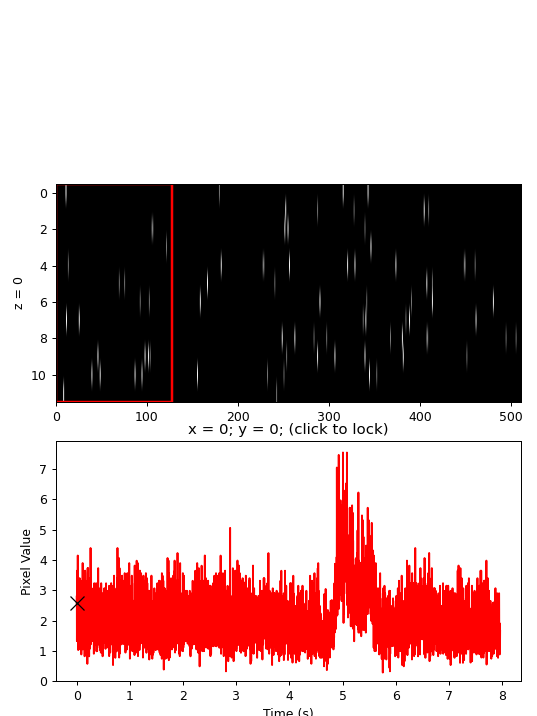

In [5]:
stack_plot = StackExplorer(
    vel_data["DD"][300],
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=(128, 12),
    vmin=0,
    figsize=(6, 8)
)
stack_plot.ax[0].set_aspect(20)
stack_plot.ax[1].set_xlabel("Time (s)")
stack_plot.ax[1].set_ylabel("Pixel Value")
stack_plot.fig.show()

### Grid ROI placement using Quality Index acceptance threshold
Take `grid_w` by `grid_h` beams from the scan field and discard those that do not meet the `min_qi` threshold.

In [122]:
grid_w = 128
grid_h = 12
min_snr = 1.

stack = vel_data["DD"][500]

grid_recs, grid_locs = [], []
for x0 in range(0, x_sz, grid_w):
    for y0 in range(0, y_sz, grid_h):
        beams = np.mean(stack[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
        grid_recs.append(beams)
        grid_locs.append([x0, y0])

grid_recs = np.stack(grid_recs, axis=1)
avg_grid_recs = np.mean(grid_recs, axis=0)
grid_locs = np.stack(grid_locs, axis=0)
print("number of grid ROIs accepted:", grid_recs.shape[1])

number of grid ROIs accepted: 4


<IPython.core.display.Javascript object>


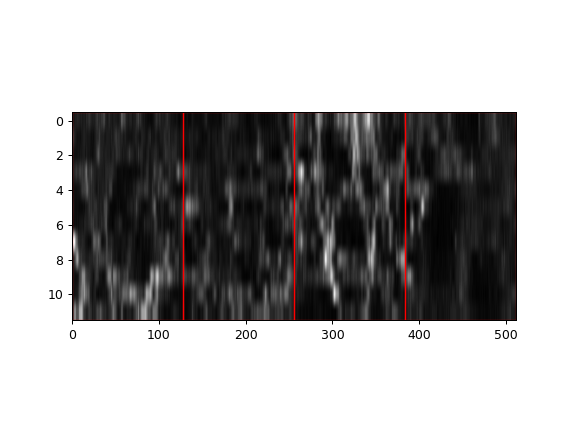

In [123]:
mean_stack_proj = np.mean(stack, axis=(0,1))

half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(1)

grid_ax.imshow(mean_stack_proj, cmap="gray", aspect=20)
for (x, y) in grid_locs:
    grid_ax.add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

<IPython.core.display.Javascript object>


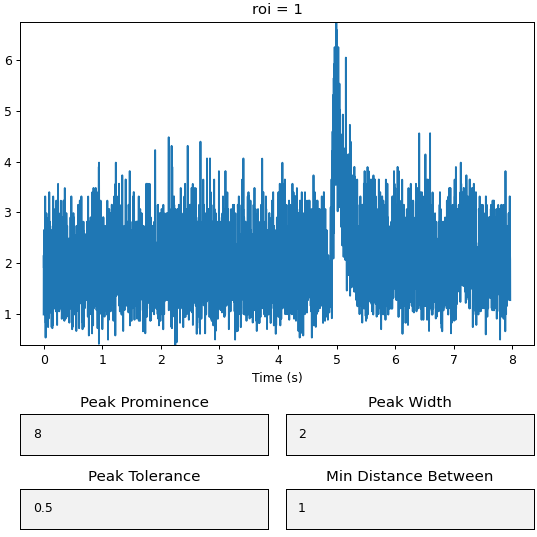

In [124]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
    grid_recs[0],
    prominence=8,
    width=2,
    tolerance=.5,
    distance=1
)

In [125]:
def mono_exp_decay(x, m, t, b):
    return m * np.exp(-t * x) + b

<ipython-input-125-659205cac9de>:2: RuntimeWarning: overflow encountered in exp
  return m * np.exp(-t * x) + b
<ipython-input-125-659205cac9de>:2: RuntimeWarning: overflow encountered in multiply
  return m * np.exp(-t * x) + b


<IPython.core.display.Javascript object>


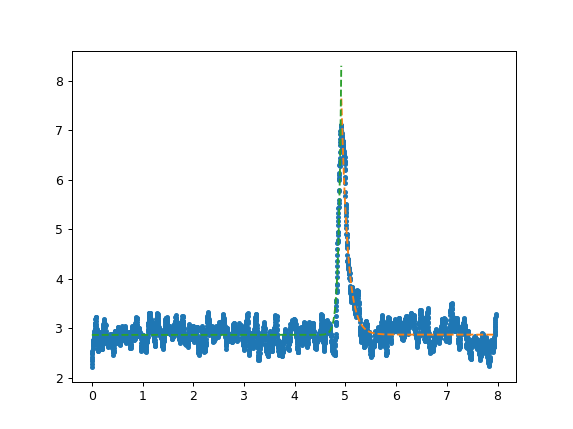

rise: Y = 5.438 * e^(-19.037 * x) + 2.869
decay: Y = 4.769 * e^(-7.987 * x) + 2.874


In [126]:
peak_idx = 2780
y = savgol_filter(grid_recs[0, 2], 51, 3)
# y = grid_recs[0, 2]

rise_p0 = (1, 100, 2.5)
rise_y = np.flip(y[:peak_idx])
rise_xaxis = recs_xaxis[:peak_idx]
rise_params, rise_cv = curve_fit(mono_exp_decay, rise_xaxis, rise_y, rise_p0)

decay_p0 = (1, 10, 3)
decay_y = y[peak_idx:]
decay_xaxis = recs_xaxis[peak_idx:] - recs_xaxis[peak_idx] 
decay_params, decay_cv = curve_fit(mono_exp_decay, decay_xaxis, decay_y, decay_p0)

fit_fig, fit_ax = plt.subplots(1)
fit_ax.plot(recs_xaxis, y, '.', label="data")
fit_ax.plot(
    decay_xaxis + recs_xaxis[peak_idx], 
    mono_exp_decay(decay_xaxis, *decay_params), 
    '--', 
    label="decay"
)
fit_ax.plot(
    rise_xaxis, 
    np.flip(mono_exp_decay(rise_xaxis, *rise_params)), 
    '--', 
    label="rise"
)

print(
    "rise: Y = %.3f * e^(-%.3f * x) + %.3f" 
    % tuple(p for p in rise_params)
)
print(
    "decay: Y = %.3f * e^(-%.3f * x) + %.3f" 
    % tuple(p for p in decay_params)
)

In [129]:
class BiexpFitter:
    def __init__(self, amp, est_tau1, est_tau2):
        self.a0 = amp
        self.b0 = amp
        a, b, g, t = sf.variables("a, b, g, t")
        tau1 = sf.Parameter("tau1", est_tau1)
        tau2 = sf.Parameter("tau2", est_tau2)        
        self.ode_model = sf.ODEModel(
            {
                sf.D(a, t): -a / tau1,
                sf.D(b, t): -b / tau2,
            },
            initial={t: 0, a: amp, b: amp},
        )
        def g_func(t, tau1, tau2):
            res = self.ode_model(t=t, tau1=tau1, tau2=tau2)
            return res.b - res.a        
        self.model = sf.CallableNumericalModel(
            {g: g_func}, 
            connectivity_mapping={g: {t, tau1, tau2}}
        )
        
    def fit(self, x, y):
        self.results = sf.Fit(self.model, t=x, g=y).execute()
        return self.results
    
    def calc_g(self, x):
        return self.model(t=x, **self.results.params)[0]
    

i0 = 2700 # 500mm
# i0 = 2600 # 300mm
# i1 = 3400
i1 = len(recs_xaxis)
y = savgol_filter(grid_recs[0, 2], 51, 3)
y_sub = y[i0:i1] - y[i0]
y_sub = y_sub / y_sub.max()
x_trunc = np.arange(i1 - i0) * (1 / 565)

# Apply model
fitter = BiexpFitter(1, 0.05, .5)
fitter.fit(x_trunc, y_sub)

<IPython.core.display.Javascript object>


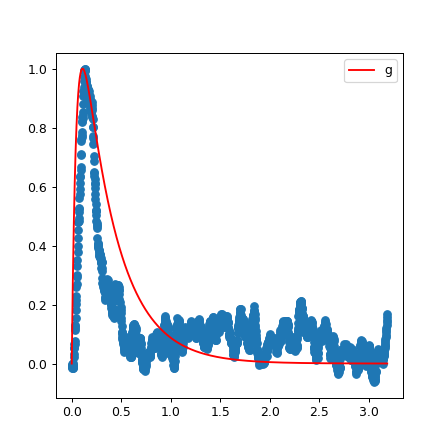

tau1: 0.047508347326132065
tau2: 0.34411215563320907


In [130]:
g = fitter.calc_g(x_trunc)

sym_fig, sym_ax = plt.subplots(1, figsize=(5, 5))
# sym_ax.plot(x_trunc, g, label="g", c="red")
sym_ax.plot(x_trunc, g * (np.max(y_sub) / np.max(g)), label="g", c="red")
sym_ax.scatter(x_trunc, y_sub)
sym_ax.legend()
sym_fig.show()

print("tau1:", fitter.results.value(tau1))
print("tau2:", fitter.results.value(tau2))

<IPython.core.display.Javascript object>


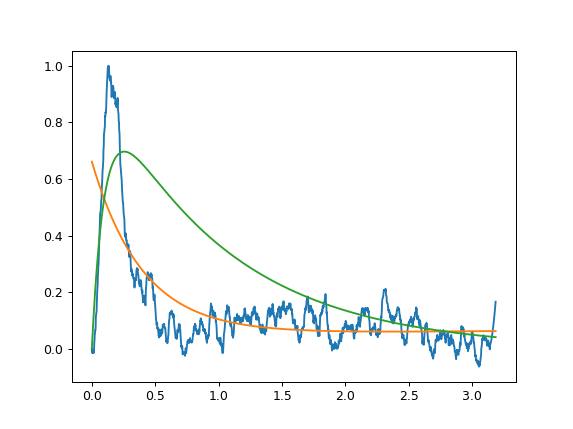

[0.61180435 2.49147454 0.0067788  0.6614151 ]


In [132]:
def biexp(x, m, t1, t2, b):
#     return m * (np.exp(-t1 * x) - np.exp(-t2 * x)) + b
#     return (m * np.exp(-t1 * x)) - (m * np.exp(-t2 * x) + b)
    return m * (np.exp(-t1 * x) - np.exp(-t2 * x)) + b

bi_params, bi_cv = curve_fit(biexp, x_trunc, y_sub, (4, .04, 1, 3))

ff, aa = plt.subplots(1)
aa.plot(x_trunc, y_sub)
aa.plot(x_trunc, biexp(x_trunc, *bi_params))
# aa.plot(x_trunc, biexp(x_trunc, 6, 0.04, 15, 3))
aa.plot(x_trunc, mono_exp_decay(x_trunc, 1, 1, 3) - mono_exp_decay(x_trunc, 1, 10, 3))
print(bi_params)

/home/geoff/miniconda3/envs/neuron/lib/python3.8/site-packages/skued/time_series/fitting.py:52: RuntimeWarning: overflow encountered in exp
  arr[time > tzero] = amp * np.exp(-(time[time > tzero] - tzero) / tconst) + offset
/home/geoff/miniconda3/envs/neuron/lib/python3.8/site-packages/skued/time_series/fitting.py:52: RuntimeWarning: overflow encountered in multiply
  arr[time > tzero] = amp * np.exp(-(time[time > tzero] - tzero) / tconst) + offset
/home/geoff/miniconda3/envs/neuron/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


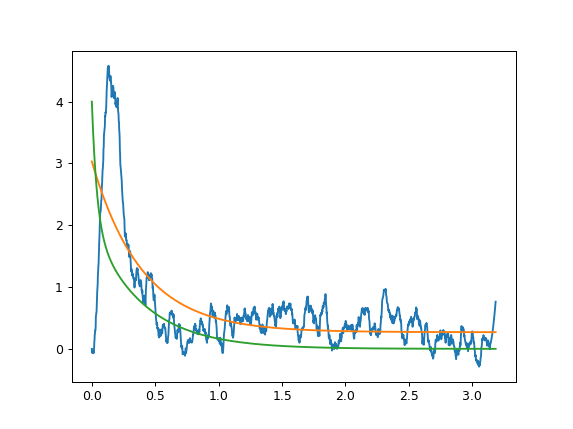

[-2.39540156e-02  1.50754627e+00  2.93590692e+00  9.11697267e-04
  3.92986162e-01  2.69629835e-01]


In [25]:
# tzero, amp1, amp2, tau1, tau2, offset
p0 = (0, 4, 4, .04, .4, 0) 
bi_params, bi_cv = curve_fit(biexponential, x_trunc, y_sub, p0)

ff, aa = plt.subplots(1)
aa.plot(x_trunc, y_sub)
aa.plot(x_trunc, biexponential(x_trunc, *bi_params))
aa.plot(x_trunc, biexponential(x_trunc, 0, 2, 2, 0.04, .4, 0))
print(bi_params)